# Project assignment

**Use Case**:

For this data science challenge I am provided with a dataset containing mobility traces of ~500 taxi cabs in San Francisco collected over ~30 days. The format of each mobility trace file is the following - each line contains (latitude, longitude, occupancy, time), e.g. (37.75134 -122.39488 0 1213084687), where latitude and longitude are in decimal degrees, occupancy shows if a cab has a fare (1 = occupied, 0 = free) and time is in UNIX epoch format.
The goala of this data science challenge are:

1. To calculate the potential for yearly reduction on CO2 emissions, caused by the taxi cabs roaming without passengers. In your calculation please assume that the taxi cab fleet is changing at the rate of 10% per month (from combustion engine-powered vehicles to electric vehicles). Assume also that the average passenger vehicle emits about 404 grams of CO2 per mile.
2. To build a predictor for taxi drivers, predicting the next place a passenger will hail a cab.

Bonus question:

3. Identify clusters of taxi cabs that you find being relevant.

## Methodology

Before diving into my solution, I would like to present the way I approached the problem. 

It is more important for me to demonstrate the way I think and approach problems than focusing on achieving high performance. I present alternative methods and other steps I could have followed on the following sections of this notebook.

### Reduction of CO2 emissions

I select only 5% of the total number of files. From these files, I keep only the coordinates where the occupancy was set to 0, since these are the points of interest. I use the current and previous coordinates to calculate the distance in miles that the cabs are doing without having passangers. Then I aggregate the total distance with 0 occupancy per driver. Finally I accumulate the distances of all drivers to have the total distance of interest for one month. I multiply the result by 12 and get the yearly distance of interest for the CO2 emissions

Then, I assume that the policy of replacing 10% of the vehicles with EVs is in place. This policy means that the number of taxis with combustion engines is reduced by 10% every month. I assume that the distance for CO2 emissions is also reduced by 10% every month. Applying this policy for 12 months gives me the new distance for the CO2 emissions with EVs.

Then, I take the two distances, divide them by 0.05 (I only took 5% of the files for my analysis) and thus approximate the total distance of all taxis. 

I get the CO2 reduction by multiplying the total distance with the number of CO2 grams per mile and comparing the results.

### Predicting next pickup point for taxi drivers

In order to tackle this problem, I create two subtasks.

1. I predict the trajectory of each taxi driver using an approach similar to time series
2. I build a classifier to predict if a location is a candidate for picking up a customer

#### Predicting trajectories
My goal is to build a model for each taxi driver that models his/her trajectory. In order to do that, I use a time series approach. I build a model that predicts the location in time `t` by taking as features the locations in `t-1, t-2, ..., t-n`. In my approach, I use a windown of 3, i.e. `n=3`. Of course, this is a hyper-parameter that needs to be exploited in order to get the best possible model. I do not do this hyper-parameter search because of time constrains.

I split my data into training and test set with a test ratio of 20%. The train/test split is not done randomly. Since I approach the problem as a time series problem, I train my trajectory predictor using the first coordinates and test on the last coordinates (end of route).

I plot the real and predicted trajectory (separate test set for that) in order to visualize how good the predicted trajectory is.

**Notes**:

* I build a trajectory predictor only for one taxi driver (selected randomly) in this assignment.
* I use a simple neural network without hyper-parameter optimization.
* I could have used other models like LSTM/GRU but could not afford the training time.
* Other algorithms like linear/polynomial regression, SVR, etc could have been used.

#### Classifier for pick-up points
I implement a Random Forest (RF) Classifier in order to predict if a location is a pick-up point. To do so, I focus on the subset of data I select (5% of the total data) and use all the datapoints. This is different compared to the trajectory prediction, where I use only one file, since I want a trajectory predictor per taxi driver, i.e. per file.

I use the coordinates, the day of week, hour and time (extracted after parsing the UNIX epoch timestamp) as features and the occupancy (0 or 1) as label. I assume that the rest of the features (seconds and year) are not very helpful.

Split my data randomly into train and test sets with a test ration of 20%. I compare the performance of the RF classifier against a naive baseline (predict always 1 for location) and see a significant improvement.

**Notes**:

* I do not do hyper-parameter optimization.
* Other algorithms logistic regression, SVM,, XgBoost, etc could have been used.

#### Getting next pick-up locations
We can get the next pick-up location by combining the trajectory predictor for each taxi driver and the pick-up point classifier.

Using the trajectory predictor, we can predict the coordinates of a taxi driver. These coordinates can be fed into the pick-up point classifier which will indicate the next pick-up location with a certain probability.

In [1]:
import random
import datetime
from os import listdir
from os.path import join as jp

import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import Series
import matplotlib.pyplot as plt
from math import radians, degrees, sin, cos, asin, acos, sqrt

from keras.models import Sequential
from keras.layers import Dense, Input, Activation, BatchNormalization, Dropout

from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

pd.options.mode.chained_assignment = None

Using TensorFlow backend.


## Task 1: Calculate CO2 reduction

First, I define some helper functions, that are used in following cells.

**Note**: I prefer to select good variable and method names and avoid documentation in order to have a cleaner and easily maintained code

In [2]:
def convert_file_into_dataframe(file_name: str):
    df = pd.read_csv(jp(path, file_name), sep=' ', header=None)
    df.index = file_name.split('.')[0] + "_" + df.index.map(str)
    df.columns = ['lattitude', 'longitude', 'occupancy', 'timestamp']
    df['taxi'] = file_name.split('.')[0]
    return df

def add_previous_coordinates(df: DataFrame):
    df['previous_lattitude'] = df.shift(1)['lattitude']
    df['previous_longitude'] = df.shift(1)['longitude']
    df = df.dropna()
    return df

def _estimate_distance_in_miles(row: Series):
    # formula taken from
    # https://medium.com/@petehouston/calculate-distance-of-two-locations-on-earth-using-python-1501b1944d97
    longitude = row['longitude']
    lattitude = row['lattitude']
    previous_longitude = row['previous_longitude']
    previous_lattitude = row['previous_lattitude']
    longitude, lattitude, previous_longitude, previous_lattitude = map(radians, 
                                                                       [longitude, lattitude, 
                                                                        previous_longitude, previous_lattitude])
    try:
        return 3958.756 * (acos(sin(lattitude) * sin(previous_lattitude) + cos(lattitude) * cos(previous_lattitude) * 
                                cos(longitude - previous_longitude)))
    except:
        return 0.0

def calculate_distance_from_coordinates(df: DataFrame):
    df['miles'] = 0.0
    df['miles'] = df.apply(lambda row: _estimate_distance_in_miles(row), axis=1)
    return df

#### Data selection

I only select randomly 5% of all the files for aforementioned reasons.

In [3]:
path = '/Users/taagiat1/Downloads/cabspottingdata/'
all_files = [file_name for file_name in listdir(path) if file_name.endswith('.txt')]
print(f'All files are {len(all_files)}')

percentage_of_files_to_select = 0.05

random.Random(5).shuffle(all_files)
selected_files = all_files[:int(percentage_of_files_to_select * len(all_files))]

print(f'\n{len(selected_files)} randomly selected files')

All files are 537

26 randomly selected files


After selecting all the data, I convert them into a dataframe that includes the distance of interest for the CO2 emissions.

In [4]:
all_data = pd.DataFrame()
for f in selected_files:
    df = convert_file_into_dataframe(file_name=f)
    df = add_previous_coordinates(df=df)
    df = calculate_distance_from_coordinates(df=df)
    all_data = pd.concat([all_data, df])

A very fast data analysis can be done using the `describe` method. There is no `nan` value (from the count field) and there are no outliers. 

By inspecting the data, I also noticed that some coordinates are places in the **Pacific ocean** but I assume that this comes for GPS error.

In [5]:
all_data.describe()

,lattitude,longitude,occupancy,timestamp,previous_lattitude,previous_longitude,miles
count,567018.000000,567018.000000,567018.000000,5.670180e+05,567018.000000,567018.000000,567018.000000
mean,37.766250,-122.412855,0.450201,1.212009e+09,37.766251,-122.412857,0.403666
std,0.048692,0.035107,0.497514,5.856945e+05,0.048688,0.035103,1.141241
min,37.267510,-123.959060,0.000000,1.211018e+09,37.267510,-123.959060,0.000000
25%,37.759490,-122.425590,0.000000,1.211506e+09,37.759490,-122.425590,0.031722
50%,37.781820,-122.411500,0.000000,1.212001e+09,37.781820,-122.411500,0.160261
75%,37.790780,-122.400910,1.000000,1.212525e+09,37.790780,-122.400910,0.322380
max,37.999750,-122.000010,1.000000,1.213088e+09,37.999750,-122.000010,85.458140


Now, I calculate for each taxi, the distance without a passanger.

In [6]:
df_no_passanger = all_data[all_data['occupancy'] == 0]
distance_without_passangers = df_no_passanger.groupby(by=['taxi'])['miles'].sum()
print(distance_without_passangers)

taxi
new_acduou       1928.825319
new_ackgrica     1520.561978
new_adpaifo      1887.044545
new_afmorc       1967.400032
new_ailbcuv      2151.976509
new_ajsnedsi     3065.646612
new_ashgati      1107.950717
new_aydwaho      2024.546007
new_eavflid      2533.041470
new_ebenfrag     2481.424806
new_eccest       2332.822815
new_eicmynts     1541.489652
new_eincufpy      410.518313
new_eitpem        988.923540
new_ekenucki     2725.079913
new_ektamy       2367.455664
new_eshroa       2891.269306
new_esnddceb     2473.422297
new_idodly       2453.106028
new_ifelas       2645.401528
new_iofplik      2755.886605
new_oapwycti     1992.035794
new_ojbaso       2361.905872
new_oljnek       3274.327074
new_osckro       2898.263218
new_upthin      52260.395227
Name: miles, dtype: float64


#### CO2 Reduction Analysis

The two following cells present the calculation of CO2 emissions before and after the ECO-friendly policy (more details are presented in the introduction).

In [7]:
distance_without_passangers_per_month = distance_without_passangers.sum()
distance_without_passangers_per_year = distance_without_passangers_per_month * 12

print(f'The distance for CO2 in one year (before the EVs) '
      f'is approx {round(distance_without_passangers_per_year)} miles\n')

distance_without_passangers_per_year_with_evs = 0.0

for month in range(12):
    if month == 0:
        distance_without_passangers_per_month_with_evs = distance_without_passangers_per_month
        distance_without_passangers_per_year_with_evs = distance_without_passangers_per_month
    else:
        distance_without_passangers_per_month_with_evs = distance_without_passangers_per_month_with_evs * 0.9
        distance_without_passangers_per_year_with_evs += distance_without_passangers_per_month_with_evs
    print(f'The distance for CO2 after {month} month(s) of'
          f'EVs is approx {round(distance_without_passangers_per_month_with_evs, 3)} miles')
    
print(f'\nThe distance for CO2 after one year of EVs '
      f'is approx {round(distance_without_passangers_per_year_with_evs)} miles')

The distance for CO2 in one year (before the EVs) is approx 1284489.0 miles

The distance for CO2 after 0 month(s) ofEVs is approx 107040.721 miles
The distance for CO2 after 1 month(s) ofEVs is approx 96336.649 miles
The distance for CO2 after 2 month(s) ofEVs is approx 86702.984 miles
The distance for CO2 after 3 month(s) ofEVs is approx 78032.685 miles
The distance for CO2 after 4 month(s) ofEVs is approx 70229.417 miles
The distance for CO2 after 5 month(s) ofEVs is approx 63206.475 miles
The distance for CO2 after 6 month(s) ofEVs is approx 56885.828 miles
The distance for CO2 after 7 month(s) ofEVs is approx 51197.245 miles
The distance for CO2 after 8 month(s) ofEVs is approx 46077.52 miles
The distance for CO2 after 9 month(s) ofEVs is approx 41469.768 miles
The distance for CO2 after 10 month(s) ofEVs is approx 37322.792 miles
The distance for CO2 after 11 month(s) ofEVs is approx 33590.512 miles

The distance for CO2 after one year of EVs is approx 768093.0 miles


In [8]:
CO2_grams_per_mile = 404
CO2_emissions_without_ev = distance_without_passangers_per_year / percentage_of_files_to_select * CO2_grams_per_mile
CO2_emissions_with_ev = distance_without_passangers_per_year_with_evs / percentage_of_files_to_select * CO2_grams_per_mile

CO2_reduction = round((CO2_emissions_without_ev - CO2_emissions_with_ev) / CO2_emissions_without_ev, 4)

print(f'The CO2 emissions are reduced by {CO2_reduction * 100}%')

The CO2 emissions are reduced by 40.2%


## Task 2: Predicting the next place a passenger will hail a cab

As mentioned in the introduction, I split this problem into two subtasks.

### Subtask 1: Predicting trajectory for a single taxi driver

As mentioned in the intro, I build a trajectory model for each taxi driver. Here, I include only one taxi driver in my analysis.

#### Data preparation

I start by normalizing my data by removing the lattitude and longitude offset of San Francisco.

In [9]:
lat_offset = 37.0
long_offset = -122.0
taxi_driver = selected_files[0]

datapoints = []
with open(file=jp(path, taxi_driver), mode='r') as f:
    for line in f:
        lat, long, occ, ts = line.split()
        datapoints.append([float(lat) - lat_offset, float(long) - long_offset])

I tackle this problem as a time series problem, thus I build the data in a format that contains `t-1, t-2, t-3` coordinates (stored in `X` matrix) and use `t` as the coordinate I want to predict (stored in `Y` matrix).

In [10]:
X = []
Y = []
window = 3
for idx in range(len(datapoints) - window):
    timesteps = datapoints[idx:idx + window]
    X.append([ts for timestep in timesteps for ts in timestep])
    Y.append(datapoints[idx + window])

Since it is a time series approach, I select the first 80% of my data to be my train set and the last 20% to be my test set.

In [11]:
training_set_size = round(len(X) * 0.8)

X_train = np.array(X[:training_set_size])
X_test = np.array(X[training_set_size:])

Y_train = np.array(Y[:training_set_size])
Y_test = np.array(Y[training_set_size:])

#### Trajectory Predictor Model

The trajectory predictor is a simple fully connected neural network with one input layer, one hidden layer and one output layer. The output activation is `linear` and the loss function is set to `MSE` since it is a regression problem.

**Note:** The reasons for not testing another model was mentioned in the introduction.

In [12]:
model = Sequential()
model.add(BatchNormalization())
model.add(Dense(4, input_shape=(6,)))
model.add(Activation('tanh'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(2))
model.add(Activation('linear'))
model.compile(loss='mean_squared_error', optimizer='Adam')

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
history = model.fit(X_train, Y_train, epochs=50, validation_data=(X_test, Y_test), verbose=1)
print(f'MSE on training set {history.history["loss"][-1].round(4)}')
print(f'MSE on testing set {history.history["val_loss"][-1].round(4)}')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 18555 samples, validate on 4639 samples
Epoch 1/50
18555/18555 [==============================] - 1s 72us/step - loss: 0.2107 - val_loss: 0.0022
Epoch 2/50
18555/18555 [==============================] - 1s 45us/step - loss: 0.0337 - val_loss: 9.2066e-04
Epoch 3/50
18555/18555 [==============================] - 1s 45us/step - loss: 0.0116 - val_loss: 6.7530e-04
Epoch 4/50
18555/18555 [==============================] - 1s 45us/step - loss: 0.0053 - val_loss: 6.4401e-04
Epoch 5/50
18555/18555 [==============================] - 1s 46us/step - loss: 0.0027 - val_loss: 5.8187e-04
Epoch 6/50
18555/18555 [==============================] - 1s 46us/step - loss: 0.0016 - val_loss: 5.6702e-04
Epoch 7/50
18555/18555 [==============================] - 1s 46us/step - loss: 0.0011 - val_loss: 5.1991e-04
Epoch 8/50
18555/18555 [=====

#### Training the neural network

The neural network is trained for 50 epoches. Bellow, the training and testing losses are depicted. From the graph, we see that the network does not overfit. I omit the loss of the first 10 epochs. Thus, the loss is already small and the difference between the train and test curve is visible. Otherwise, the loss at the beginning of the training is big and the two curves cannot be distinguished (matter of scaling in the y-axis).

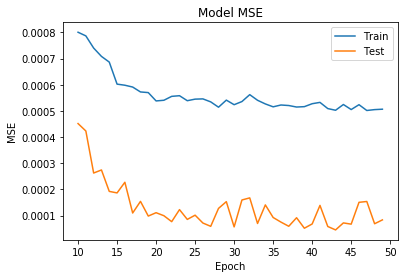

In [14]:
_, ax = plt.subplots()
ax.plot(history.history['loss'][10:])
ax.plot(history.history['val_loss'][10:])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
ax.set_xticklabels(np.arange(5, 55, 5))
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

#### Predicting trajectories

I used the trained model and the `X_test` in order to make predictions for the last part of the trajectory. I do not present the loss since a loss in distance in coordinates is tough to interpret. On the contrary, I choose to present the **true (on the left)** and **predicted (on the right)** trajectory of the taxi driver. From the graphs, we see that the model did a good job.

In [15]:
Y_pred = model.predict(X_test)

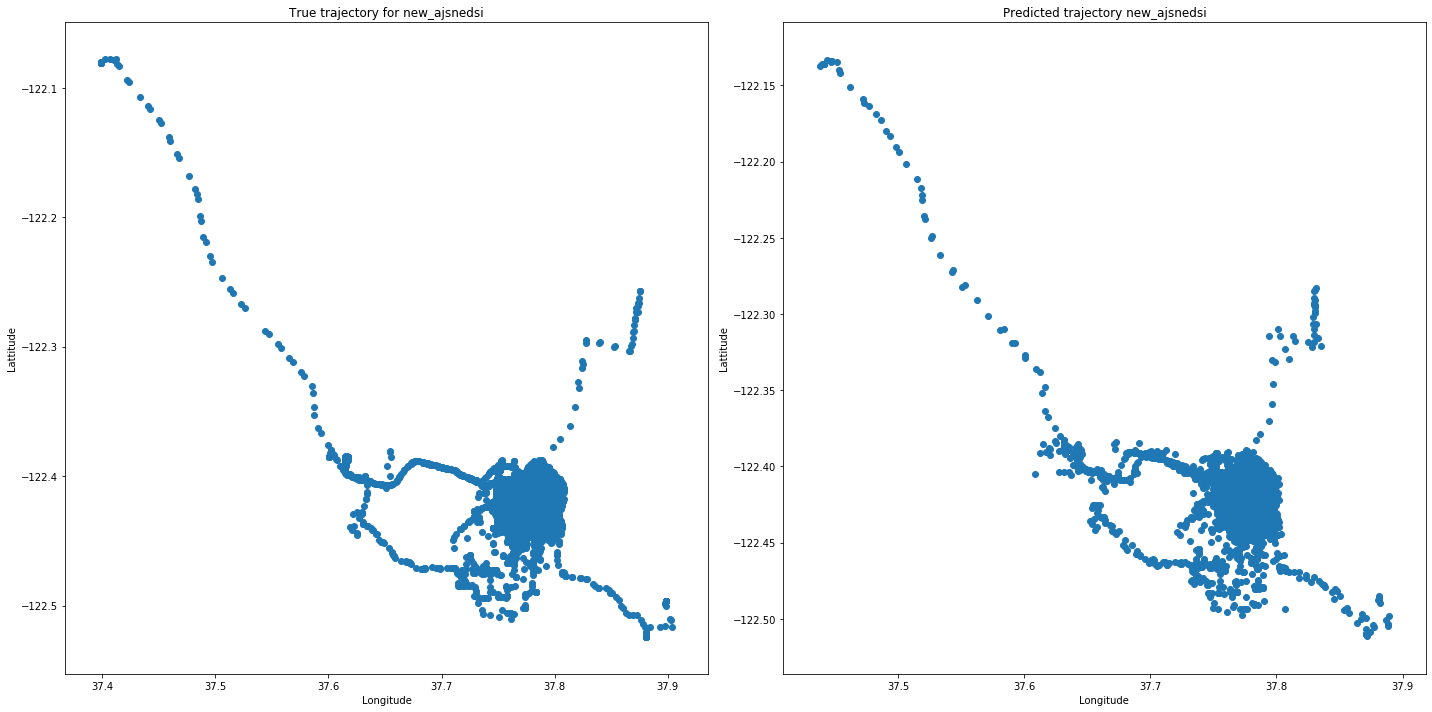

In [16]:
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.scatter(Y_test[:,0] + lat_offset, Y_test[:,-1] + long_offset)
plt.title('True trajectory for {}'.format(taxi_driver.split('.')[0]))
plt.ylabel('Lattitude')
plt.xlabel('Longitude')
plt.subplot(122)
plt.scatter(Y_pred[:,0] + lat_offset, Y_pred[:,-1] + long_offset)
plt.title('Predicted trajectory {}'.format(taxi_driver.split('.')[0]))
plt.ylabel('Lattitude')
plt.xlabel('Longitude')
plt.tight_layout()

### Subtask 2: Pick-up Location Classifier

The second subtask focuses on a classifier for detecting pick-up locations.

To do so, I use the location, day of week, hour and minute as features and build a model to classify if a location (coordinates) on a particular day and a particular time is a pick-point.

**Assumption:** For simplicity, I assume that every single datapoint with `occupancy=1` is a candidate pick-up point, i.e. I do not consider as pick-up points only the datapoints with coordindate where occupancy switches from 0 to 1. 

#### Data preparation

First, I start by converting the UNIX timestamp into a `datatime` object so that I can extract the day of the week, the hour and the minute.

In [17]:
def extract_date_time(row: Series):
    dt = datetime.datetime.fromtimestamp(row['timestamp'])
    row['day'] = dt.weekday()
    row['hour'] = dt.hour
    row['minute'] = dt.minute
    return row

In [18]:
data = all_data[['lattitude', 'longitude', 'occupancy', 'timestamp']]
data['day'] = 0
data['hour'] = 0
data['minute'] = 0
data = data.apply(lambda row: extract_date_time(row), axis=1)
data.head()

,lattitude,longitude,occupancy,timestamp,day,hour,minute
new_ajsnedsi_1,37.75124,-122.39527,0.0,1.211022e+09,5.0,13.0,6.0
new_ajsnedsi_2,37.75027,-122.39532,0.0,1.211022e+09,5.0,13.0,7.0
new_ajsnedsi_3,37.75224,-122.39650,0.0,1.211023e+09,5.0,13.0,8.0
new_ajsnedsi_4,37.75281,-122.39083,0.0,1.211023e+09,5.0,13.0,9.0
new_ajsnedsi_5,37.76503,-122.39311,0.0,1.211023e+09,5.0,13.0,10.0


Now, I build the `X` matrix containing my features and the `Y` matrix containing the labels. Once again, I normalize the longitude and lattitude values.

In [19]:
X = data.drop(labels=['occupancy', 'timestamp'], axis=1)
X['lattitude'] = X['lattitude'] - lat_offset
X['longitude'] = X['longitude'] - long_offset

Y = data['occupancy']

I continue by splitting randomly my data into train and test sets with a ration of 80-20.

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, test_size=0.2, random_state=0)

#### Baseline Model

I select a naive baseline model that predicts always 0 for the next location.

In [21]:
baseline_acc = round(Y_test[Y_test == 0].shape[0] / Y_test.shape[0], 3)
print(f'The baseline accuracy of a naive model is {baseline_acc}')

The baseline accuracy of a naive model is 0.55


#### Random Forests

Then I build an AI-based classifier using Random Forests (RF) in order to predict if a datapoint is a pick-up location or not. RF outperforms the baseline approach significantly.

**Note:** Other AI-based approaches are not tested for the reasons stated in the introduction.

In [22]:
clf = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=0)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
acc = round(accuracy_score(Y_test, Y_pred), 3)
print(f'The accuracy is {acc}')

The accuracy is 0.698


#### Evaluation metric

I use accuracy as a metric, since the problem seems to be balanced (55% of the labels are 0 and 45% of the labels are 1). In a scenario with higher imbalance I could have used F-score.

#### Feature importance

We can also inspect and interpret the trained RF classifier by analyzing the importance of each feature. It looks like the coordindates are the most important features to classify a pick-up point whereas the day feature does not help the classifier a lot.

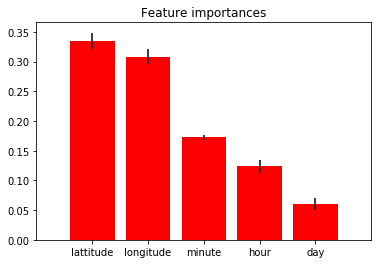

In [23]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), [X_train.columns.tolist()[idx]  for idx in indices])
plt.xlim([-1, X_train.shape[1]])
plt.show()

### Combining Subtasks 1 and 2

We can now use the trajectory predictor or Subtask 1 to pinpoint the next location of a taxi driver based on his current and last two positions. 

Using mechanisms like the speed of the taxi, etc. we can estimate the arrival time in position that is predicted. This can work as input in the pick-up location classifier of subtask 2 in order to classify if the next point is a pick-up point or not. 

We can determine the next pick-up point (and thus solve Task 2) by repeating this process for the whole predicted trajectory of the taxi.

## Bonus: Cluster Identification

For the bonus task, I focus on clustering the locations where the taxis 
* have passangers
* do not have passangers

In [24]:
def visualize_dbscan(db: DBSCAN, X: DataFrame):

    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    labels = db.labels_
    
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)

    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
            continue

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask].values
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask].values
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()

### Clusters were taxis are occupied
I use the `all_data` dataframe which contains all the datapoints I have selectes (5% of the total number of files). From these datapoints, I select those with `occupancy = 1` since I want to cluster the points where taxis are occupied.

For computational reasons I select only 30% of these datapoints (notebook kernel dies with more datapoints). 

I demand the neighbouring point to have a max distance of 0.0005 degrees (approx 50 meters) and I require that each cluster has at least 50 datapoints. This means that at least 50 passangers are in a taxi in an area with radius 50 meters.

I compare the results of DBSCAN with an online resource (image attached) that shows the pickup heatmap in San Francisco. The comparison verifies that the results of DBSCAN are very close to the reality since most of the pickup happen in San Francisco Downtown

Estimated number of clusters: 133


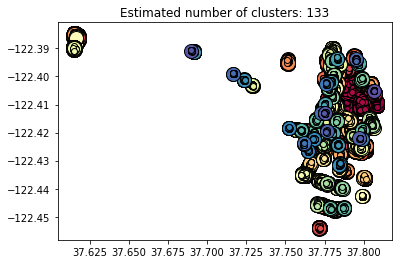

In [25]:
sampled_data = all_data[all_data['occupancy'] == 1][['lattitude', 'longitude']].sample(frac=0.3, random_state=0)

db = DBSCAN(eps=0.0005, min_samples=50)
db.fit(sampled_data)
visualize_dbscan(db=db, X=sampled_data)

<img src="files/images/pickup_heatmap.jpg">

### Clusters were taxis are non occupied
I follow the same approach as before but not I focus on datapoints where taxis have no passangers, i.e. datapoints with `occupancy = 0`.

Once again, I compare the results of DBSCAN with an online resource (image attached), that shows the cab stations in San Francisco. Once again, the comparison verifies that the DBSCAN results are reasonable since most taxi cab stations are in San Francisco Downtown around hotels.

Estimated number of clusters: 133


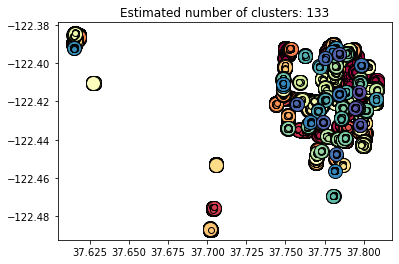

In [26]:
sampled_data = all_data[all_data['occupancy'] == 0][['lattitude', 'longitude']].sample(frac=0.3, random_state=0)

db = DBSCAN(eps=0.0005, min_samples=50)
db.fit(sampled_data)
visualize_dbscan(db=db, X=sampled_data)

<img src="files/images/taxi_station.png">